In [19]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
import numpy as np
import pandas as pd
import random
from torch.nn import functional as F
import albumentations as A
import cv2
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import time
import math
import matplotlib.pyplot as plt
from PIL import Image
from randaugment import RandAugment
import warnings
warnings.filterwarnings("ignore")

In [6]:
# generate all image path dir = "research_fishes"
def generate_imgs_file(dir):
    import glob
    path_dic = []
    
    fh = open('research_fishes/summary.txt', 'r')
    label_index = []
    for index,line in enumerate(fh):
        label_index.append((line.split()[0],index))
    label_indexs = dict(label_index)
    
    for index,value in enumerate(label_indexs.keys()):
        #print(type(i))
        paths = glob.glob(dir + "/*/"+ value +"/*.png")

        for path in paths:
            path_dic.append([path,index])
    
    path_dic = pd.DataFrame(path_dic,columns = ['path','label'])
    return path_dic

# the target training dataset, we need to add two random augmentation to a sample
# and feed these two image to student and teacher to calculate the consistency
class MyDataset2(Dataset): 
    def __init__(self, path_dic, transform=None, randaugment=None):

        self.imgs = list(path_dic.to_records(index=False))
        self.transform = transform
        self.randaugment = randaugment
        
    def __getitem__(self, index):
        path, label = self.imgs[index]
        
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transform is not None:
            img1 = self.transform(image=img)["image"]
            img2 = self.transform(image=img)["image"]
            
        if self.randaugment is not None:
            #
            img1 = Image.fromarray(np.uint8(img1)).convert('RGB')
            img2 = Image.fromarray(np.uint8(img2)).convert('RGB')
            
            img1 = self.randaugment(img1)
            img2 = self.randaugment(img2)

        return img1,img2,label
    
    def __len__(self):
        return len(self.imgs)
    
# pytorch built in dataset read image and transform data
class MyDataset(Dataset): 
    def __init__(self, path_dic, transform=None, randaugment=None):

        self.imgs = list(path_dic.to_records(index=False))
        self.transform = transform
        self.randaugment = randaugment
        
    def __getitem__(self, index):
        path, label = self.imgs[index]
        
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transform is not None:
            img = self.transform(image=img)["image"]
            
        if self.randaugment is not None:
            img = Image.fromarray(np.uint8(img)).convert('RGB')

            img = self.randaugment(img)

        return img,label
    
    def __len__(self):
        return len(self.imgs)
    
# WeightedRandomSampler function(class imbalance)
def getSampler(labels):
    # get the unqiue label and counts
    class_sample_count = np.unique(labels, return_counts=True)[1]
    # assign a weight to every sample
    class_weights = 1./torch.tensor(class_sample_count, dtype=torch.float) 
    class_weights_all = class_weights[labels]
    
    sampler = torch.utils.data.sampler.WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
    )
    return sampler

# generate studenta and teacher model
def get_model_strcure(student_path = None, teacher_path = None):
    
    if student_path == None:
        s_pretrained = True
        print("student use pretrain parameter")
    else:
        # if didn't use pretrain parameter, it will load train source parameter
        s_pretrained = False
        
    if teacher_path == None:
        t_pretrained = True
        print("teacher use pretrain parameter")
    else:
        t_pretrained = False
        
    student = torchvision.models.resnet152(pretrained=s_pretrained)
    student.fc = nn.Sequential(
                nn.Linear(2048,1024),
                nn.ReLU(),
                nn.Linear(1024, 1024),
                nn.ReLU(),
                nn.Linear(1024,13)
    )
    teacher = torchvision.models.resnet152(pretrained=t_pretrained)
    teacher.fc = nn.Sequential(
                nn.Linear(2048,1024),
                nn.ReLU(),
                nn.Linear(1024, 1024),
                nn.ReLU(),
                nn.Linear(1024,13)
    )
    
    if (student_path != None) & (teacher_path != None):
        # generate teacher_optimizer before load model parameter 
        # load two train source network, because OldWeightEMA initial function will make student and teacher network has same paramter"""
        teacher_optimizer = OldWeightEMA(teacher, student, alpha=teacher_alpha)
        print("because load two model, so generate teacher_optimizer before load model parameter")
        
        
    if student_path != None:
        student.load_state_dict(torch.load(student_path))
        print("student load success")
        
    if (t_pretrained == False) & (teacher_path != None):
        teacher.load_state_dict(torch.load(teacher_path))
        print("teacher load success")
        
    try:
        teacher_optimizer
        print("didn't generate teacher_optimizer before load model")
    except:
        print("generate a new teacher_optimizer and make student and teacher model has same parameter")
        teacher_optimizer = OldWeightEMA(teacher, student, alpha=0.99)
        
    return student, teacher, teacher_optimizer

def get_default_device():
    # Set Device to GPU or CPU
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    # Move data to the device
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking = True)

class DeviceDataLoader():
    # Wrap a dataloader to move data to a device
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        # Yield a batch of data after moving it to device
        for b in self.dl:
            yield to_device(b,self.device)
            
    def __len__(self):
        # Number of batches
        return len(self.dl)

    
class OldWeightEMA (object):
    
    # Exponential moving average weight optimizer for mean teacher model
    def __init__(self, target_net, source_net, alpha=0.999):
        self.target_params = list(target_net.parameters())
        self.source_params = list(source_net.parameters())
        self.alpha = alpha

        # initialize student and teacher network make them same"""
        for p, src_p in zip(self.target_params, self.source_params):
            p.data[:] = src_p.data[:]

    def step(self):
        one_minus_alpha = 1.0 - self.alpha
        for p, src_p in zip(self.target_params, self.source_params):
            p.data.mul_(self.alpha)
            p.data.add_(src_p.data * one_minus_alpha)
            

def compute_aug_loss(stu_out, tea_out, ground_truth, rampup_weight = None):
    # consistency loss
    
    if use_rampup:
        conf_mask_count = 0
        threshold_acc = 0
        
        d_aug_loss = stu_out - tea_out
        aug_loss = d_aug_loss * d_aug_loss
        aug_loss = aug_loss.mean(dim=1)
        unsup_loss = aug_loss.mean() * rampup_weight
    else:
        conf_tea, preds = torch.max(tea_out, 1)
        conf_mask = conf_tea > confidence_thresh
        threshold_acc = torch.sum(preds[conf_mask] == ground_truth[conf_mask])
        conf_mask = conf_mask.int()
        conf_mask_count = conf_mask.sum() # count how many over confidence threshold
        
        #mean square error
        d_aug_loss = stu_out - tea_out
        aug_loss = d_aug_loss * d_aug_loss
        aug_loss = aug_loss.mean(dim=1)
        unsup_loss = (aug_loss * conf_mask).mean()
    return unsup_loss, conf_mask_count, threshold_acc

@torch.no_grad()
def train_pred(X_sup):
    student.eval()
    teacher.eval()
    return student(X_sup), teacher(X_sup)

@torch.no_grad()
def f_eval_src(val_dl,num):

    stu_num = 0
    tea_num = 0
    for X_sup, y_sup in val_dl:

        y_pred_prob_stu, y_pred_prob_tea = train_pred(X_sup)
        _, y_pred_stu = torch.max(y_pred_prob_stu, dim=1)
        _, y_pred_tea = torch.max(y_pred_prob_tea, dim=1)

        stu_num += torch.tensor(torch.sum(y_pred_stu != y_sup).item())
        tea_num += torch.tensor(torch.sum(y_pred_tea != y_sup).item())
    # return the error rate
    return [stu_num/num,tea_num/num]

# write the training history
def logfile(text):
    print(text)
    if log_file is not None:
        with open(log_file, 'a') as f:
            f.write(text + '\n')
            f.flush()
            f.close()

# genereate rampup weight follow Gaussian rampup curve
def get_rampup_list(epochs, rampup):
    rampup_weight_list = []
    for epoch in range(epochs):
        if epoch < rampup:
            p = max(0.0, float(epoch)) / float(rampup)
            p = 1.0 - p
            rampup_value = math.exp(-p * p * 5.0)
        else:
            rampup_value = 1.0

        rampup_weight_list.append(rampup_value)
    
    return rampup_weight_list

def fit():

    
    loss_his1 = []
    loss_his2 = []
    error_rate = []
    mask_his = []
    mask_acc_his = []
    log=[]

    for epoch in range(epochs):

        t1 = time.time()

        student.train()
        teacher.train()
        train_losses = []
        unsup_losss = []
        conf_mask_counts = 0
        mask_accs = 0

        for (batch),(X_tgt0,X_tgt1,targ_label) in zip(sour_train_dl,targ_train_dl):

            X_src, y_src = batch
            src_logits_out = student(X_src)
            sup_loss = F.cross_entropy(src_logits_out, y_src)   # supervised loss
            
            #possibility vector for example, [0.4, 0.2, 0.3, 0.1] sum = 1
            student_tgt_logits_out = student(X_tgt0)
            student_tgt_prob_out = F.softmax(student_tgt_logits_out, dim=1)
            teacher_tgt_logits_out = teacher(X_tgt1)
            teacher_tgt_prob_out = F.softmax(teacher_tgt_logits_out, dim=1)
            
            if use_rampup:
                unsup_loss, conf_mask_count, mask_acc = compute_aug_loss(student_tgt_prob_out, teacher_tgt_prob_out,targ_label, rampup_weight_list[epochs])
            else:
                unsup_loss, conf_mask_count, mask_acc = compute_aug_loss(student_tgt_prob_out, teacher_tgt_prob_out,targ_label)
                
            conf_mask_counts += conf_mask_count
            mask_accs += mask_acc

            # loss  = cross entropy of supervised loss + consistency cost * constant（unsup_weight）
            loss = sup_loss + unsup_loss * unsup_weight

            train_losses.append(loss)
            unsup_losss.append(unsup_loss)

            loss.backward()
            optimizer.step()
            teacher_optimizer.step()
            optimizer.zero_grad()

        # learning rate schedule step each epoch
        if scheduler != None:
            scheduler.step()
        
        # 2000 is the number of test sample
        log.append(f_eval_src(sour_val_dl,2000))
        log.append(f_eval_src(targ_val_dl,2000))

        loss_his1.append(torch.stack(train_losses).mean().item())
        loss_his2.append(torch.stack(unsup_losss).mean().item())

        t2 = time.time()

        if use_rampup:
            mask_his.append(conf_mask_counts)
            mask_acc_his.append(mask_accs)
        else:
            mask_his.append(conf_mask_counts.item())
            mask_acc_his.append(mask_accs.item())
        

        logfile('Epoch {} took {:.2f}s: TRAIN clf loss={:.6f}, Un super loss={:.6f}; SRC TEST student ERR={:.6%}, SRC TEST teacher ERR={:.6%},'
                'TGT TEST student err={:.6%}, TGT TEST teacher err={:.6%}, larger than {}, the {} of {} is correctly, mask rate is {:.2%}'
                'learning rate {:.6f}'.format(
             epoch, t2 - t1, loss_his1[epoch], loss_his2[epoch], log[2*epoch][0], log[2*epoch][1],
                log[2*epoch+1][0],log[2*epoch+1][1], confidence_thresh, mask_acc_his[epoch], mask_his[epoch], mask_acc_his[epoch]/mask_his[epoch],
                    optimizer.param_groups[0]['lr']))                                             
    
        # store model paramter after training
        if epoch == epochs - 1:
            model_name = str(experi_num) + "epoch" + str(epochs)
            torch.save(student.state_dict(), model_name + "student")
            torch.save(teacher.state_dict(), model_name + "teacher")


In [7]:
def get_dataloader(train_transform, val_transform, randaugment = None):  
    # Because the amount of data is too small, in order to ensure that a part of the data（valid_sour_idx and valid_targ_idx） will never be trained.
    # The training dataset and validation dataset of each model are the same.
    train_sour_idx = np.load('train_sour_idx.npy')
    valid_sour_idx = np.load('valid_sour_idx.npy')

    train_targ_idx = np.load('train_targ_idx.npy')
    valid_targ_idx = np.load('valid_targ_idx.npy')

    path_dic = generate_imgs_file('research_fishes')
    path_dic2 = generate_imgs_file('commercial_fishes')    
    
    source_data = MyDataset(path_dic, transform = train_transform, randaugment = randaugment)
    source_data2 = MyDataset(path_dic, transform = val_transform)
    target_data = MyDataset2(path_dic2, transform = train_transform, randaugment = randaugment)
    target_data2 = MyDataset(path_dic2, transform = val_transform)

    sour_train_data = Subset(source_data, indices=train_sour_idx)
    sour_val_data = Subset(source_data2, indices=valid_sour_idx)
    targ_train_data = Subset(target_data, indices=train_targ_idx)
    targ_val_data = Subset(target_data2, indices=valid_targ_idx)

    sour_train_labels = []
    for train_index in sour_train_data.indices:
        sour_train_labels.append(source_data.imgs[train_index][1])
    sour_train_labels = torch.tensor(sour_train_labels)
    sour_sampler = getSampler(sour_train_labels)

    targ_train_labels = []
    for train_index in targ_train_data.indices:
        targ_train_labels.append(target_data.imgs[train_index][1])
    targ_train_labels = torch.tensor(targ_train_labels)
    targ_sampler = getSampler(targ_train_labels)

    #V100, 36,36,32,32 num_workers = 4, a image is 110 MB
    #Rtx 60.60.64.64
    
    if torch.cuda.get_device_name() == "Tesla V100-PCIE-16GB":
        batch_list = [36, 36]
    elif torch.cuda.get_device_name() == "Quadro RTX 6000":
        batch_list = [60, 64]
    else:
        print("please specific the batch size in new GPU Node")
    sour_train_dl = DataLoader(sour_train_data, shuffle=False, batch_size=batch_list[0], sampler=sour_sampler, num_workers = 4, pin_memory = True)
    targ_train_dl = DataLoader(targ_train_data, shuffle=True, batch_size=batch_list[1], num_workers = 4, pin_memory = True)
    sour_val_dl = DataLoader(sour_val_data, batch_size=batch_list[1], num_workers = 4, pin_memory = True)
    targ_val_dl = DataLoader(targ_val_data, batch_size=batch_list[1], num_workers = 4, pin_memory = True)

    device = get_default_device()
    print(device)

    sour_train_dl = DeviceDataLoader(sour_train_dl, device)
    sour_val_dl = DeviceDataLoader(sour_val_dl, device)
    targ_train_dl = DeviceDataLoader(targ_train_dl, device)
    targ_val_dl = DeviceDataLoader(targ_val_dl, device)
    
    return sour_train_dl, sour_val_dl, targ_train_dl, targ_val_dl, device

In [16]:
def update(value):
    #                name             confidence   un_weight	basemodel	learn	rampup	randaugment	frozen	alpha    
    df = pd.read_csv("Result.csv")
    
    if value is not None:
        df.loc[df.shape[0],:] = value
        df.to_csv("Result.csv", index=False)

    pd.set_option("max_rows", None)

    columns = ["super_loss", "un_super_loss", "SRC_student", "SRC_teacher", "TGT_student", "TGT_teacher", 'student',"teacher"]
    for i in columns:
        df[i] = 0
        df[i] = df[i].astype(object)
    print(df.shape)
    #columns = ["super_loss", "un_super_loss", "SRC_student", "SRC_teacher", 'student', "TGT_student", "TGT_teacher", "teacher"]

    mask = []
    im = []
    for index, name in enumerate(df.name):
        import re
        last_epoch = 10
        mean = []
        std = []
        
        f = open("log/"+name, "r")
        fs = f.read()

        b = re.findall(r'of (.*?) ', fs)
        a = re.findall(r'the (.*?) of', fs)

        b = list(map(float, b))
        a = list(map(float, a))

        a=np.array(a, dtype=np.float)
        b=np.array(b, dtype=np.float)

        P1 = re.findall(r'SRC TEST student ERR=(.*?)%', fs)
        P2 = re.findall(r'SRC TEST teacher ERR=(.*?)%', fs)
        L1 = re.findall(r'TRAIN clf loss=(.*?),', fs)

        P3 = re.findall(r'TGT TEST student err=(.*?)%', fs)
        P4 = re.findall(r'TGT TEST teacher err=(.*?)%', fs)
        L2 = re.findall(r'Un super loss=(.*?);', fs)

        P1 = list(map(float, P1))[-last_epoch:]
        P2 = list(map(float, P2))[-last_epoch:]
        L1 = list(map(float, L1))[-last_epoch:]
        P3 = list(map(float, P3))[-last_epoch:]
        P4 = list(map(float, P4))[-last_epoch:]
        L2 = list(map(float, L2))[-last_epoch:]


        mean.append(round(np.array(L1).mean(),4))
        std.append(round(np.array(L1).std(),4))

        mean.append(round(np.array(L2).mean(),5))
        std.append(round(np.array(L2).std(),5))

        mean.append(round(100-np.array(P1).mean(),2))
        std.append(round((100-np.array(P1)).std(),2))

        mean.append(round(100-np.array(P2).mean(),2))
        std.append(round((100-np.array(P2)).std(),2))

        mean.append(round(100-np.array(P3).mean(),2))
        std.append(round((100-np.array(P3)).std(),2))

        mean.append(round(100-np.array(P4).mean(),2))
        std.append(round((100-np.array(P4)).std(),2))

        mean.append(round((mean[2]+mean[4])/2, 2))
        std.append(round((std[2]+std[4])/2, 2))

        mean.append(round((mean[3]+mean[5])/2, 2))
        std.append(round((std[3]+std[5])/2, 2))


        df.at[index, columns] = mean
        
        mask.append((a[-20:]/b[-20:]).mean())
        im.append((b[-20:]/7620).mean())
        
    df['mask'] = np.round(mask,3)
    df['im'] = np.round(im,3)
    return df

In [8]:
def get_transform(randaugment = None):  
    # default data augmentatation
    train_transform = A.Compose(
        [
            A.Affine(translate_px={"x":(-2,2),"y":(-2,2)}, scale = (0.75,1.333), rotate = 180, p = 0.5),
            A.GaussNoise(var_limit = (10,100), p = 0.5),
            #A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2,p=0.2),
            A.CoarseDropout(max_holes=1, max_height=60, max_width=60, min_holes=1,fill_value=64, p = 0.6),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ],
    )
    # validation data augmentation
    val_transform = A.Compose(
        [
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ],
    )
    
    if randaugment:
        # randaugment 
        randaugment = transforms.Compose(
        [
            RandAugment(),
            transforms.ToTensor(), 
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
        ])

        train_transform = A.Compose(
        [
            A.Affine(translate_px={"x":(-2,2),"y":(-2,2)}, scale = (0.75,1.333), rotate = 180, p = 0.5),
            A.GaussNoise(var_limit = (10,100), p = 0.5),
            A.CoarseDropout(max_holes=1, max_height=60, max_width=60, min_holes=1,fill_value=64, p = 0.6),
        ])
        
    else:
        print("don't need randaugment")
    
    return train_transform, val_transform, randaugment

def print_log():
    logfile("train_transform = " + str(train_transform) + "\n randaugment = " + str(randaugment) +  "\n initial learning rate = " + str(lr)
        + "\n unsup_weight = " + str(unsup_weight)  + "\n use_rampup = " + str(use_rampup) 
        + "\n rampup = " + str(rampup) + "\n student_path = " + str(student_path)  
        + "\n teacher_path = " + str(teacher_path) + "\n the log file explaination = " + str(explaination)
        + "\n experi_num = " + str(experi_num) + "\n Epochs = " + str(epochs)
        + "\n teacher_alpha " + str(teacher_alpha) + "\n GPU = " + str(torch.cuda.get_device_name())
           )
    if scheduler:
        logfile("\n scheduler = " + str(scheduler.state_dict()))
    else:
        logfile("no scheduler")
    if confidence_thresh:
        logfile("\n confidence_thresh = " + str(confidence_thresh))
    else:
        logfile("No confidence_thresh")
    
    l = 0
    for param in list(student.parameters()):
        if param.requires_grad:
            l+=1
    if l != 471:
        logfile("\n the student model has frezon layer, the number is " + str(471-l))

In [ ]:
randaugment = None # True
train_transform, val_transform, randaugment = get_transform(randaugment = randaugment)

sour_train_dl, sour_val_dl, targ_train_dl, targ_val_dl, device = get_dataloader(train_transform, val_transform, randaugment)

student_path =  "trainSourceOnly10_epoch100"
teacher_path =  None #"modelParameter/Meanteacher09_02/Meanteacher09_Epoch161teacher"

unsup_weight = 10        # unsuervised weight
confidence_thresh = 0.85 # confidence threshold to teacher network 
lr = 0.0001              # initial learning rate
epochs = 200             # epochs 
teacher_alpha = 0.99     # EMA alpha
Frozen_layer = False     # Frozen_layer can be 33, 11, 108, 435 layer

student, teacher, teacher_optimizer = get_model_strcure(student_path, teacher_path)
student = to_device(student, device)
teacher = to_device(teacher, device)

optimizer = torch.optim.Adam(student.parameters(),lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)
log_file = "log/test"
use_rampup = False  # use_rampup = True, use rampup
rampup = False      # ramup value(80 common)
experi_num = "changeBatch1"  # the name of save model  
# just clarify the model detail
explaination = "confidence_threshold 0.85*5, No frozen and alpha 0.99 and change 12 60 batch size and all parameter is default  and no base model"



teacher_params = list(teacher.parameters())
for param in teacher_params:
    param.requires_grad = False

if Frozen_layer:
    for i in range(Frozen_layer):
        list(student.parameters())[i].requires_grad = False

if use_rampup:
    rampup_weight_list = get_rampup_list(use_rampup, epochs, rampup)

# all variables don’t need to be changed during training so just set up here
print_log()
fit()

In [20]:
# show all result and accuracy
df = update(value =None)
df

(132, 17)


,name,confidence,un_weight,basemodel,learn,rampup,randaugment,frozen,alpha,super_loss,un_super_loss,SRC_student,SRC_teacher,TGT_student,TGT_teacher,student,teacher,mask,im
0,Meanteacher01,0.9,10.0,0.0,0,0.0,0.0,0.0,0.9900,0.016,0.00094,88.03,82.71,62.47,66.18,75.25,74.44,0.556,0.974
1,Meanteacher01_02,0.9,10.0,0.0,0,0.0,0.0,0.0,0.9900,0.0188,0.00115,88.84,83.04,51.61,55.58,70.22,69.31,0.548,0.968
2,Meanteacher02,0.9,10.0,0.0,0,0.0,0.0,0.0,0.9900,0.0176,0.00106,88.71,83.71,59.15,62.51,73.93,73.11,NaN,NaN
3,Meanteacher05,0.9,10.0,0.0,0,0.0,0.0,0.0,0.9900,0.0178,0.00102,88.41,84.2,51.29,52.25,69.85,68.22,0.569,0.970
4,Meanteacher03,0.95,10.0,0.0,0,0.0,0.0,0.0,0.9900,0.0168,0.00098,89.14,85.16,47.59,48.17,68.37,66.66,0.545,0.953
5,Meanteacher04,0.9,10.0,0.0,cosine,0.0,0.0,0.0,0.9900,0.0139,0.00091,89.54,86.44,50.27,52.66,69.9,69.55,0.556,0.956
6,Meanteacher06,0.9,10.0,1.0,0,0.0,0.0,0.0,0.9900,0.0158,0.00098,88.97,86.85,63.24,67.08,76.1,76.96,0.599,0.975
7,Meanteacher07,0.95,10.0,1.0,1,0.0,0.0,0.0,0.9900,0.0045,0.00038,89.12,85.39,69.45,72.28,79.28,78.84,0.667,0.976
8,Meanteacher08,0.97,10.0,1.0,0,0.0,0.0,0.0,0.9900,0.0049,0.00036,89.28,87.53,64.18,67.28,76.73,77.4,0.612,0.969
9,Meanteacher09,0.85,10.0,1.0,0,0.0,0.0,0.0,0.9900,0.0173,0.00122,88.82,86.32,65.01,70.12,76.91,78.22,0.593,0.979


In [46]:
def get_bounding_box(img,size = 12):
    h_list=[]
    w_list=[]
    for i in range(224):
        #print(img1[i])
        for j in img[i]:
            if np.array_equal(j,[124, 116, 104]) == False:
                h_list.append(i)
                break
    for i in range(224):
        #print(img1[i])
        for j in img[:,i]:
            if np.array_equal(j,[124, 116, 104]) == False:
                w_list.append(i)
                break
    #plt.imshow(img[h_list[0]:h_list[-1],w_list[0]:w_list[-1]])
    return [h_list[0], h_list[-1], w_list[0], w_list[-1]]

In [53]:
def get_prob(input_image, label, model = teacher):
    input_image = val_transform(image=input_image)["image"]

    input_image = input_image.reshape(1,3,224,224)

    input_image = to_device(input_image,device)

    output = F.softmax(model(input_image), dim=1).detach().cpu().numpy()
    prob = output.tolist()[0][label]
    pred_stu = np.argmax(output, axis=1)[0]
    return prob, pred_stu

In [232]:
def plot_cut_off(position, image = image, occ_size = occ_size, occ_stride = occ_stride):
    #position = np.array([3,4])
    position = position * occ_stride
    [top, bottom, left, right] = get_bounding_box(image)
    input_image = image.copy()
    input_image[position[0]+top:position[0]+occ_size+top, position[1]+left:position[1]+occ_size+left] = input_image[0:1, 0:1]
    f, (fig1,fig2,fig3) = plt.subplots(1,3,figsize=(10,32))
    fig1.imshow(image)
    #f1, fig2 = plt.subplots(1,1)
    fig2.imshow(input_image)
    fig3.imshow(image[position[0]+top:position[0]+occ_size+top, position[1]+left:position[1]+occ_size+left])

In [384]:
def occlusion(img_num, occ_size = 30, occ_stride = 10):
#     occ_size = 30
#     occ_stride = 10

    sample_dic = path_dic2.iloc[img_num].to_dict()
    path = sample_dic['path']
    label = sample_dic['label']

    img = cv2.imread(path)
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    #get the width and height of the image
    # width, height = image.shape[0], image.shape[1]


    [top, bottom, left, right] = get_bounding_box(image)

    height = bottom - top
    width = right - left
    
    #setting the output image width and height
    output_height = int(np.ceil((height-occ_size)/occ_stride)) + 1
    output_width = int(np.ceil((width-occ_size)/occ_stride)) + 1

    #create a white image of sizes we defined
    probability_heatmap = torch.zeros((output_height, output_width))
    most_probable_heatmap = torch.zeros((output_height, output_width))

    alpha_map = np.zeros((224,224))
    alpha_map_fre = np.zeros((224,224))

    #iterate all the pixels in each column
    for h in range(0, output_height):
        for w in range(0, output_width):

            h_start = h*occ_stride + top
            w_start = w*occ_stride + left
            h_end = h_start + occ_size
            w_end = w_start + occ_size

            if w_end > right:
                w_start = right - occ_size
                w_end = right
                #print(h_start,h_end, w_start,w_end)
            elif h_end > bottom:
                h_start = bottom - occ_size
                h_end = bottom
                #print(h_start,h_end, w_start,w_end)

            input_image = image.copy()

            input_image[h_start:h_end, w_start:w_end] = input_image[0:1, 0:1]

            alpha_map_fre[h_start:h_end, w_start:w_end] += 1

            prob, pred_class = get_prob(input_image,label)

            alpha_map[h_start:h_end, w_start:w_end] += prob

            #setting the heatmap location to probability value
            probability_heatmap[h, w] = prob
            most_probable_heatmap[h, w] = pred_class
            
    import seaborn as sns
    import matplotlib.pyplot as plt
    if width>=height:
        figure_size = (22,round(10/width*height))
        figure_size2 = (10-2,round(10/width*height)-1)
    else:
        figure_size = (round(10/height*width)*2+2,10)
        figure_size2 = (round(10/height*width)-2,10-1)

    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=figure_size)
    ax1.imshow(image[top:bottom, left:right])
    ax1.set_title(get_prob(image,label))
    ax2 = sns.heatmap(probability_heatmap, xticklabels=True, yticklabels=True, annot=True)
    ax2.set_title("label is "+str(label))
    fig1, (ax3, ax4) = plt.subplots(1, 2,figsize=figure_size)
    #fig = plt.figure(figsize=figure_size2)
    ax3.imshow(image[top:bottom, left:right])
    ax3.imshow(1-(alpha_map[top:bottom, left:right]/alpha_map_fre[top:bottom, left:right]), alpha=0.4,cmap='Purples')
    ax4 = sns.heatmap(most_probable_heatmap, xticklabels=True, yticklabels=True,annot=True,cbar=False)
    ax4.set_title('most possbility class')
    #plt.show()

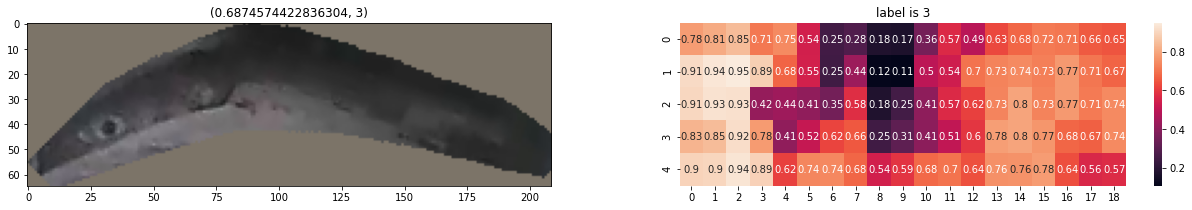

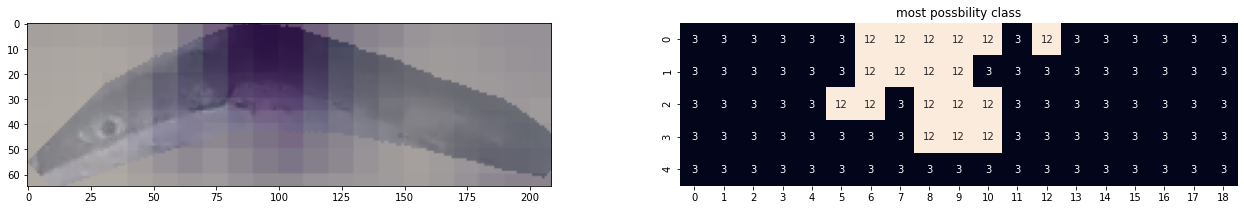

In [385]:
occlusion(5000) # experiment class, square mask 30 50 50, explanation PPT. 